In [47]:
# generate the pointcloud from a specific viewpoint 
import random
from glob import glob 
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

dirpath = '/home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetRenderings/02818832/e91c2df09de0d4b1ed4d676215f46734/'
camera_path = '/home/aditya/Research/phd/code/depth_renderer/datasets/camera_settings/cam_RT/'

color_images = sorted(glob(dirpath + '/*.png'))
depth_images = sorted(glob(dirpath + '/*.exr'))
camera_transforms = sorted(glob(camera_path + '/*.txt'))

random_idx = random.randint(0, len(color_images)-1)

rgb_image = color_images[random_idx]
depth_image = depth_images[random_idx]
camera_transform = camera_transforms[random_idx]

print(f'rgb image : {rgb_image}, depth image : {depth_image}, camera transform : {camera_transform}')

rgb image : /home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetRenderings/02818832/e91c2df09de0d4b1ed4d676215f46734/color_016.png, depth image : /home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetRenderings/02818832/e91c2df09de0d4b1ed4d676215f46734/depth_016.exr, camera transform : /home/aditya/Research/phd/code/depth_renderer/datasets/camera_settings/cam_RT/cam_RT_016.txt


In [46]:
random_idx = random.randint(0, len(color_images)-1)

rgb_image2 = color_images[random_idx]
depth_image2 = depth_images[random_idx]
camera_transform2 = camera_transforms[random_idx]

print(f'rgb imgage : {rgb_image2}, depth image : {depth_image2}, camera transform : {camera_transform2}')

rgb imgage : /home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetRenderings/02818832/e91c2df09de0d4b1ed4d676215f46734/color_008.png, depth image : /home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetRenderings/02818832/e91c2df09de0d4b1ed4d676215f46734/depth_008.exr, camera transform : /home/aditya/Research/phd/code/depth_renderer/datasets/camera_settings/cam_RT/cam_RT_008.txt


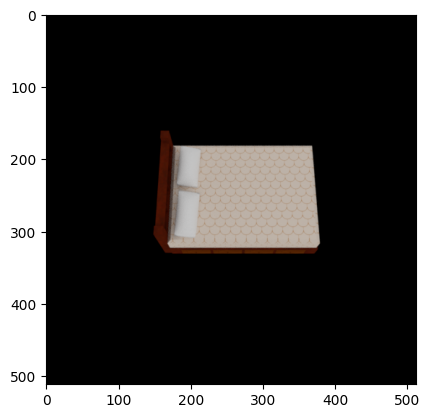

In [50]:
import matplotlib.pyplot as plt 
import cv2

rgb = cv2.cvtColor(cv2.imread(rgb_image), cv2.COLOR_BGR2RGB)
depth = cv2.imread(depth_image, cv2.IMREAD_ANYDEPTH)

rgb2 = cv2.cvtColor(cv2.imread(rgb_image2), cv2.COLOR_BGR2RGB)
depth2 = cv2.imread(depth_image2, cv2.IMREAD_ANYDEPTH)

height, width, _ = rgb.shape

plt.imshow(rgb)

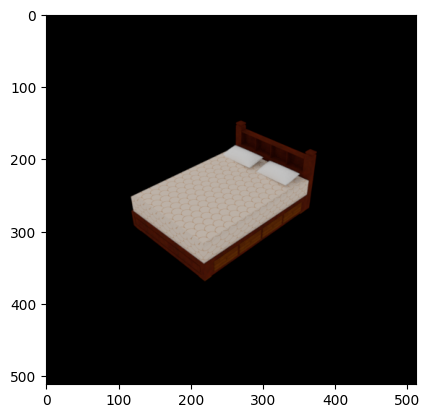

In [49]:
plt.imshow(rgb2)

In [51]:
import numpy as np

# read the camera parameters (camera intrinsics) 
camk_path = '/home/aditya/Research/phd/code/depth_renderer/datasets/camera_settings/cam_K/cam_K.txt'

with open(camk_path, 'r') as f: 
    intrinsics = [[int(float(num)) for num in line.split(' ')] for line in f]
    
fx, fy, cx, cy = intrinsics[0][0], intrinsics[1][1], intrinsics[0][2], intrinsics[1][2]
print(f'Intrinsics are : {fx, fy, cx, cy}')

# read the camera extrinsics (camera transformation)
with open(camera_transform, 'r') as f:
    camera_matrix = np.asarray([[float(num) for num in line.split(' ')] for line in f])
    
with open(camera_transform2, 'r') as f:
    camera_matrix2 = np.asarray([[float(num) for num in line.split(' ')] for line in f])
    
camera_matrix = np.vstack([camera_matrix, [0, 0, 0, 1]])
camera_matrix2 = np.vstack([camera_matrix2, [0, 0, 0, 1]])
print(f'Camera matrix is : {camera_matrix}')
print(f'Camera matrix2 is : {camera_matrix2}')

Intrinsics are : (560, 560, 256, 256)
Camera matrix is : [[ 3.63437742e-08 -2.07237179e-08 -9.99999940e-01  1.32839499e-08]
 [ 9.34172153e-01 -3.56822520e-01  4.39901378e-08  0.00000000e+00]
 [-3.56822520e-01 -9.34172213e-01  2.07237179e-08  2.07846117e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Camera matrix2 is : [[-7.07107365e-01  3.11168868e-09  7.07106411e-01 -3.01757240e-07]
 [-4.08248246e-01 -8.16496491e-01 -4.08248812e-01 -8.94069672e-08]
 [ 5.77349842e-01 -5.77350438e-01  5.77350557e-01  2.07846117e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [61]:
# generate the view-dependent partial pointcloud using the camera intrinsics, color and depth images 
import open3d as o3d

def generate_pcd(rgb, depth):
    o3d_rgb = o3d.geometry.Image(rgb)
    o3d_depth = o3d.geometry.Image(depth)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d_rgb, o3d_depth, convert_rgb_to_intensity=False)
    pinhole_camera = o3d.camera.PinholeCameraIntrinsic(
        width,
        height, 
        fx, 
        fy, 
        cx, 
        cy
    )
    
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, pinhole_camera)

    return pcd
    
    # visualize the pointcloud after flipping it 
#     transformation = [
#         [1, 0, 0, 0],
#         [0, -1, 0, 0],
#         [0, 0, -1, 0],
#         [0, 0, 0, 1]
#     ]
#     # pcd.transform(transformation)
#     coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.001)
#     o3d.visualization.draw_geometries([pcd, coordinate_frame])

pcd1 = generate_pcd(rgb, depth)
pcd2 = generate_pcd(rgb2, depth2)

o3d.visualization.draw_geometries([pcd1, pcd2])

# transform the pointclouds to get them in the world coordinate frame 
world_to_camera1 = np.linalg.inv(camera_matrix)
world_to_camera2 = np.linalg.inv(camera_matrix2)

pcd1_world = pcd1.transform(world_to_camera1)
o3d.visualization.draw_geometries([pcd1_world])
pcd2_world = pcd2.transform(world_to_camera2)
o3d.visualization.draw_geometries([pcd2_world])

pcd_combined = pcd1_world + pcd2_world
o3d.visualization.draw_geometries([pcd_combined])

In [69]:
points1_cam = np.array(pcd1.points)
points1_canonical = (points1_cam - camera_matrix[:-1, -1]).dot(camera_matrix[:-1, :-1])

pcd1_canonical = o3d.geometry.PointCloud()
pcd1_canonical.points = o3d.utility.Vector3dVector(points1_canonical)
pcd1_canonical.colors = o3d.utility.Vector3dVector(np.array(pcd1.colors))

o3d.visualization.draw_geometries([pcd1_canonical])

points2_cam = np.array(pcd2.points)
points2_canonical = (points2_cam - camera_matrix2[:-1, -1]).dot(camera_matrix2[:-1, :-1])

pcd2_canonical = o3d.geometry.PointCloud()
pcd2_canonical.points = o3d.utility.Vector3dVector(points2_canonical)
pcd2_canonical.colors = o3d.utility.Vector3dVector(np.array(pcd2.colors))

o3d.visualization.draw_geometries([pcd2_canonical])

o3d.visualization.draw_geometries([pcd1_canonical, pcd2_canonical])

In [38]:
points = np.array(pcd.points)
colors = np.array(pcd.colors)

R = camera_matrix[:-1, :-1]
T = camera_matrix[:-1, -1]

print(f'R shape : {R.shape}, T shape : {T.shape}, pointcloud shape : {points.shape}')

# transformed_points = (R @ points.T).T + T
transformed_points = 
print(f'Transformed points shape : {transformed_points.shape}')
transformed_pcd = o3d.geometry.PointCloud()
transformed_pcd.points = o3d.utility.Vector3dVector(transformed_points)
transformed_pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([pcd]) # original pcd 
o3d.visualization.draw_geometries([transformed_pcd]) # transformed pcd 

R shape : (3, 3), T shape : (3,), pointcloud shape : (31046, 3)
Transformed points shape : (31046, 3)


In [105]:
depth_map = depth
rgb_img = rgb
cam_K = intrinsics
cam_RT = camera_matrix[:-1,:]
print(cam_RT)

# print(np.array(pcd.colors).shape)

def gen_pcd(depth_map, rgb_img, cam_K, cam_RT):
    u, v = np.meshgrid(range(depth_map.shape[1]), range(depth_map.shape[0]))
    u = u.reshape([1, -1])[0]
    v = v.reshape([1, -1])[0]

    z = depth_map[v, u]

    # remove infinitive pixels
    non_inf_indices = np.argwhere(z < np.inf).T[0]

    color_indices = rgb_img[v, u][non_inf_indices]/255.0
    
    z = z[non_inf_indices]
    u = u[non_inf_indices]
    v = v[non_inf_indices]

    # calculate coordinates
    x = (u - cam_K[0][2]) * z / cam_K[0][0]
    y = (v - cam_K[1][2]) * z / cam_K[1][1]

    point_cam = np.vstack([x, y, z]).T

    point_canonical = (point_cam - cam_RT[:, -1]).dot(cam_RT[:,:-1])
    cam_pos = - cam_RT[:, -1].dot(cam_RT[:,:-1])
    focal_point = ([0, 0, 1] - cam_RT[:, -1]).dot(cam_RT[:,:-1])
    up = np.array([0,-1,0]).dot(cam_RT[:,:-1])

    print(f'points in the camera frame : {point_cam.shape}, points in the canonical frame : {point_canonical.shape}')

    # generate the pointclouds -- pointcloud in the camera frame
    cam_pcd = o3d.geometry.PointCloud()
    cam_pcd.points = o3d.utility.Vector3dVector(point_cam)
    cam_pcd.colors = o3d.utility.Vector3dVector(color_indices)

    # pointcloud in the canonical frame 
    can_pcd = o3d.geometry.PointCloud()
    can_pcd.points = o3d.utility.Vector3dVector(point_canonical)
    can_pcd.colors = o3d.utility.Vector3dVector(color_indices)
    
    return cam_pcd, can_pcd # returns the pcd in the camera frame and the canonical frame 

# generate the pointcloud using the predefined method and using the method provided in open3d to get the scaling and coordinate system right


cam_pcd1, can_pcd1 = gen_pcd(depth, rgb, intrinsics, camera_matrix[:-1, :])
cam_pcd2, can_pcd2 = gen_pcd(depth2, rgb2, intrinsics, camera_matrix2[:-1, :])

# o3d.visualization.draw_geometries([cam_pcd])
# o3d.visualization.draw_geometries([can_pcd])

# o3d.visualization.draw_geometries([cam_pcd, can_pcd])

o3d.visualization.draw_geometries([cam_pcd1, cam_pcd2])
o3d.visualization.draw_geometries([can_pcd1, can_pcd2])

[[ 3.63437742e-08 -2.07237179e-08 -9.99999940e-01  1.32839499e-08]
 [ 9.34172153e-01 -3.56822520e-01  4.39901378e-08  0.00000000e+00]
 [-3.56822520e-01 -9.34172213e-01  2.07237179e-08  2.07846117e+00]]
points in the camera frame : (32845, 3), points in the canonical frame : (32845, 3)
points in the camera frame : (30590, 3), points in the canonical frame : (30590, 3)


In [112]:
# transforming the pointclouds using the matrices 
cam_RT_inv1 = np.linalg.inv(camera_matrix)
cam_RT_inv2 = np.linalg.inv(camera_matrix2)

cam_pcd1_world = cam_pcd1.transform(cam_RT_inv1)
cam_pcd2_world = cam_pcd2.transform(cam_RT_inv2)

cam_pcd1_w = cam_pcd1.transform(camera_matrix)
cam_pcd2_w = cam_pcd2.transform(camera_matrix2)

o3d.visualization.draw_geometries([cam_pcd1_world, cam_pcd2_world])
o3d.visualization.draw_geometries([cam_pcd1_w, cam_pcd2_w])
o3d.visualization.draw_geometries([cam_pcd1, cam_pcd2])

In [89]:
print(color_indices)

[[66 17  5]
 [69 19  5]
 [69 19  5]
 ...
 [75 20  5]
 [69 19  6]
 [59 16  4]]
